In [42]:
from datetime import date, datetime, timedelta
import pymysql
import csv
import os
from pandas import DataFrame
import pandas as pd
from sqlalchemy import create_engine
import mysql.connector
from mysql.connector import errorcode
import glob
import logging
import pandas as pd
from IPython.display import display
pd.options.display.max_columns = None
# for advanced visualizations
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
#import plotly.figure_factory as ff
# for basic visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import line_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from nltk import sent_tokenize
from nltk import pos_tag, sent_tokenize, wordpunct_tokenize
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/exue001c/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##https://www.kaggle.com/roshansharma/amazon-alexa-reviews


### Configure log information 

In [2]:
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='mylog.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

### Connect to mysql database

In [3]:
try:
    cnn = mysql.connector.connect(
    user='root',
    password='root',
    host='127.0.0.1',
    database='Amazon_review',
    port='3307')
    print ("Amazon_review connection works!")
    cursor = cnn.cursor()
    
except mysql.connector.Error as e:
    if e.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with Username or Password")
    elif e.errno == errorcode.ER_BAD_DB_ERROR:
        print("database Does not exist")
    else:
        print(e)

cursor.execute("show tables;")
results = cursor.fetchall()
logging.info('***********************************************')
logging.info(results)

Amazon_review connection works!


In [4]:
cursor.execute("select product_id, rating,helpful_votes, review_date, title, review from helpful_review;")
amazon_full = cursor.fetchall()
num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]
df = pd.DataFrame(amazon_full, columns=field_names)   

In [5]:
t = 'January 5, 2020'.replace(",", "")
t = t.replace(" ", "-")
print(t)
date_object = datetime.strptime(t, "%B-%d-%Y")
date_object


January-5-2020


datetime.datetime(2020, 1, 5, 0, 0)

### Format the data 

In [6]:
df['rating']=pd.to_numeric(df['rating'])
df['helpful_votes']=pd.to_numeric(df['helpful_votes'])
df['review_date']=df['review_date'].apply(lambda x: datetime.strptime(x.replace(",", "").replace(" ", "-"), "%B-%d-%Y"))
#df['review_date'] = df['review_date'].apply(lambda x: )
df['review_len'] = df['review'].apply(len)
df['title_len'] = df['title'].apply(len)
df.describe(include='all')
# add length of the review
# adding a length column for analyzing the length of the reviews

#display(df.groupby('review_len').describe().sample(10))
#display(df.groupby('title_len').describe().sample(10))


,product_id,rating,helpful_votes,review_date,title,review,review_len,title_len
count,2484,2484.000000,2484.000000,2484,2484,2484,2484.000000,2484.000000
unique,14,NaN,NaN,941,1858,2456,NaN,NaN
top,B07H7Q1DFP,NaN,NaN,2020-01-05 00:00:00,Five Stars,Great,NaN,NaN
freq,746,NaN,NaN,14,120,7,NaN,NaN
first,NaN,NaN,NaN,2008-07-19 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2020-01-25 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,4.489533,0.464573,NaN,NaN,NaN,167.948873,22.015298
std,NaN,1.053680,2.697076,NaN,NaN,NaN,185.553985,15.949697
min,NaN,1.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,4.000000,0.000000,NaN,NaN,NaN,53.000000,11.000000


In [7]:
display(df.review_date.value_counts())
display(pd.DataFrame(df.groupby('rating')['product_id','helpful_votes'].describe(include='all')))


2020-01-05    14
2019-12-12    12
2019-07-09    11
2019-08-23    11
2019-09-18    11
2019-12-14    11
2019-06-24    10
2019-07-22    10
2019-12-17    10
2019-12-26    10
2019-12-16    10
2019-07-17    10
2019-12-21     9
2019-10-08     9
2019-02-24     9
2019-12-18     9
2019-10-04     9
2020-01-11     9
2019-06-19     9
2019-07-24     9
2020-01-03     9
2019-12-27     9
2019-07-08     9
2019-11-18     9
2020-01-12     8
2019-09-17     8
2020-01-21     8
2019-12-15     8
2019-11-14     8
2019-12-31     8
              ..
2017-08-23     1
2018-04-28     1
2017-01-12     1
2019-01-01     1
2017-09-01     1
2018-04-17     1
2017-10-30     1
2018-07-19     1
2017-05-14     1
2016-11-26     1
2017-03-21     1
2018-08-31     1
2018-10-25     1
2017-03-29     1
2017-10-06     1
2018-07-03     1
2018-06-10     1
2018-06-12     1
2016-08-26     1
2018-10-18     1
2017-07-19     1
2015-09-12     1
2015-06-03     1
2018-08-29     1
2017-09-23     1
2018-12-01     1
2016-08-04     1
2017-04-09    

product_id                                                             \
            count unique         top freq mean  std  min  25%  50%  75%  max   
rating                                                                         
1.0           114     11  B01IBUD24G   23  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2.0            82     11  B07H7Q1DFP   19  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3.0           138     11  B01IBUD24G   41  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4.0           290     14  B07H7Q1DFP   73  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5.0          1860     14  B07H7Q1DFP  601  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

       helpful_votes                                                          \
               count unique top freq      mean       std  min  25%  50%  75%   
rating                                                                         
1.0            114.0    NaN NaN  NaN  0.868421  1.737220  0.0  0.0  0.0  1.0   
2.0             82.0    NaN NaN  NaN  0.365854  1.222345  0.0  0.0  0.0  0.0   
3.0            138.0    NaN NaN  NaN  0.710145  2.327879  0.0  0.0  0.0  0.0   
4.0            290.0    NaN NaN  NaN  0.713793  2.734658  0.0  0.0  0.0  0.0   
5.0           1860.0    NaN NaN  NaN  0.387097  2.806211  0.0  0.0  0.0  0.0   

              
         max  
rating        
1.0      9.0  
2.0     10.0  
3.0     21.0  
4.0     27.0  
5.0     76.0

### Rating Distribution

In [8]:
ratings = df['rating'].value_counts().sort_index(ascending=False)

label_rating = ratings.index
size_rating = ratings.values

colors = ['pink', 'lightblue', 'aqua', 'gold', 'crimson']

rating_piechart = go.Pie(labels = label_rating,
                         values = size_rating,
                         marker = dict(colors = colors),
                         name = 'Alexa', hole = 0.3)

rating_df = [rating_piechart]

layout = go.Layout(
           title = 'Distribution of Ratings for Crutch Pad')

fig = go.Figure(data = rating_df,
                 layout = layout)

py.iplot(fig)
display(ratings)

5.0    1860
4.0     290
3.0     138
2.0      82
1.0     114
Name: rating, dtype: int64

By looking at the above pie chart, we can infer that most of the Ratings are good for 14 Cruch pad products. Around 74.9% people have given this product 5 Star rating on amazon, which is very good. 11.7% people have given these products a 4 Star Rating, which is also good. that means 74.9+11.7 ~ 87% people have given Cruch pad good rating.

A total of 3.3+4.59 ~8% people did not like Cruch pad they purchased.



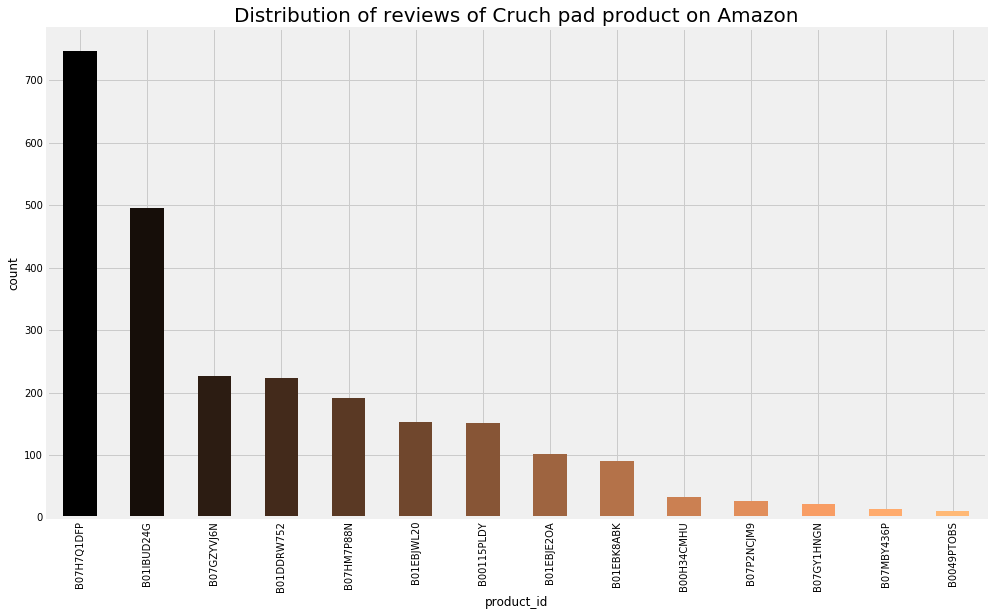

In [9]:
color = plt.cm.copper(np.linspace(0, 1, 15))
df['product_id'].value_counts().plot.bar(color = color, figsize = (15, 9))

plt.title('Distribution of reviews of Cruch pad product on Amazon', fontsize = 20)
plt.xlabel('product_id')
plt.ylabel('count')
plt.show()

The above Bar plot, plots the different cruch pad product with their popularity or no. of counts.

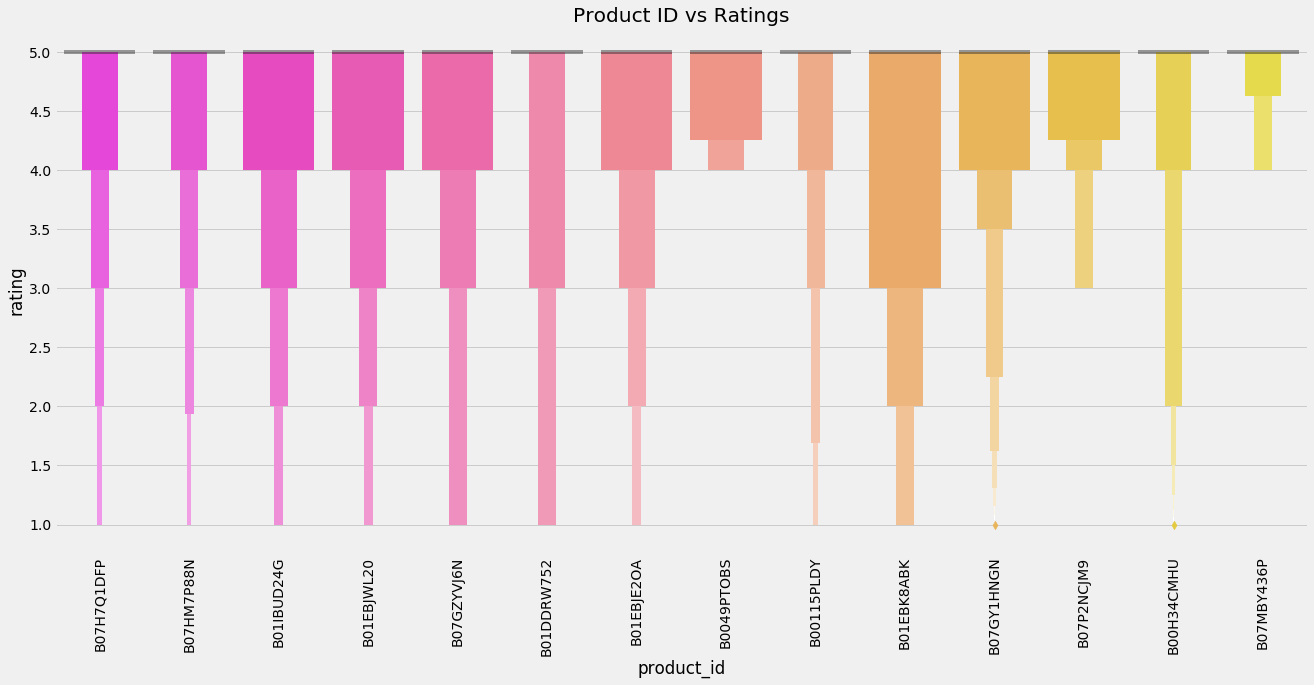

In [10]:
plt.rcParams['figure.figsize'] = (20, 9)
plt.style.use('fivethirtyeight')

sns.boxenplot(df['product_id'], df['rating'], palette = 'spring')
plt.title("Product ID vs Ratings")
plt.xticks(rotation = 90)
plt.show()

The above Box plot, plots the distribution of the rating for each product. 

In [ ]:
# df['review_len'].value_counts().plot.hist(color = 'skyblue', figsize = (15, 5), bins=np.linspace(0, 25, 5))
# plt.style.use('fivethirtyeight')
# plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
# plt.title('Distribution of Length in Reviews')
# plt.xlabel('lengths')
# plt.ylabel('count')
# plt.show()
# df['title_len'].value_counts().plot.hist(color = 'skyblue', figsize = (15, 5), bins=np.linspace(0, 150, 10))
# plt.title('Distribution of Length in Title')
# plt.xlabel('lengths')
# plt.ylabel('count')
# plt.show()

The above Distribution Plot, shows a distribution of Length of the Reviews/title written by the customers. Most of the Reviews are are pretty short. 

In [12]:
# #check some reviews by length
# df[df['review_len'] == 4]['review']

51      Like
465     Love
1877    Crap
1886    Good
2109    Like
2336    Nice
Name: review, dtype: object

In [11]:
insignificant_taglist1= ['DT', 'CC','PRP','PRP$','IN','.','TO',"''",',','WRB','RP','WP','WDT',
         'EX','UH','$',':','FW','WP$','LS','SYM','VBD','VB','VBP','VBZ','VBG','VBN']
insignificant_taglist2 = ['DT', 'CC','PRP','PRP$','IN','.','TO',"''",',','WRB','RP','WP','WDT',
                                              'EX','UH','$',':','FW','WP$','LS','SYM']
significant_taglist_N =['NN','JJ','JJR','JJS','NNS','NNP','NNPS','PDT','POS']
significant_taglist_V =['RB','RBR','RBS','VB','VBD','VBN','VBP','VBZ','VBG']

In [12]:
def filter_insignificant(chunk, tag_suffixes =insignificant_taglist1):     
    good = [] 
    for word, tag in chunk: 
        if tag in tag_suffixes: 
            continue
        good.append((word, tag))   
    return good


def keep_significant(chunk, tag_suffixes =significant_taglist_N):
    good = [] 
    for word, tag in chunk: 
        if tag not in tag_suffixes: 
            continue
        good.append((word, tag))   
    return good 

In [38]:
def Normalize_Tokens(review_series, flag):
    review_list=review_series.tolist()
    
    v_tokenized = [nltk.word_tokenize(message) for message in review_list]
    v_tokenized_tag = [pos_tag(nltk.wordpunct_tokenize(message.encode("utf-8"))) for message in review_list]
    #display(v_tokenized[:10])
    #display(v_tokenized_tag[:10])
    display(len(v_tokenized)) 
    stop_words = stopwords.words('english')
    stop_words_skip =[]
    #["don't","aren't","couldn't","didn't","doesn't","hadn't","hasn't","haven't","isn't","mightn't",
    #                 "mustn't","needn't","shan't","shouldn't","wasn't","weren't","wouldn't","won't"]
    self_define_stop_wrods=['nan','crutch']
    stop_words_selfdefined=[i for i in stop_words if i not in stop_words_skip ]+self_define_stop_wrods
    ps = PorterStemmer()
    lemmatizer=WordNetLemmatizer()
    # Create a list for clean messages.
    tokens_len=len(v_tokenized)
    v_prelim = [None] * tokens_len
    v_lemma = [None] * tokens_len
    v_lemma_counts_per_survey = [None] * tokens_len
    # Prep data and Bag-of-Words Analysis
    for i in range(len(v_tokenized)):
        # filter insignificant tag
        #v_prelim[i] = [word for word, tag in filter_insignificant(token_tag[i],filter_tag)]
        # filter insignificant tag
        # 1. Convert to lower case.
        v_prelim[i] = [message.lower() for message in v_tokenized[i]]
        # 2. Remove stopwords.
        v_prelim[i] = [word for word in v_prelim[i] if not word in stop_words_selfdefined]
        v_prelim[i] = [word for word in v_prelim[i] if not word in stop_words]

        # 3. Remove punctuation and any non-alphabetical characters.
        v_prelim[i] = [word for word in v_prelim[i] if word.isalpha()]
        # 4. Stem words.
        # Lemmitize words and record the word count
        v_lemma[i] = [ps.stem(word) for word in v_prelim[i]]
        #v_lemma[i] = [lemmatizer.lemmatize(word) for word in v_prelim[i]]
        #print(document[i])
        #print(v_lemma[i] )
        v_lemma_counts_per_survey[i] = len(v_lemma[i])
        #print v_lemma[i]
    
    
    # Array with length of each survey
    word_counts_array_lemma = np.array(v_lemma_counts_per_survey)
    v_lemma_array = np.array(v_lemma)
    doc_array = np.array(review_series)
    print('Original Survey Size %s'%(len(v_lemma_array)))

    # Find indices of all messages where there are at least 1 words.
    #valid_v_lemma = np.where(word_counts_array_lemma >= 1)[0]
    #invalid_v_lemma = np.where(word_counts_array_lemma < 1)[0]
    #valid_v_lemma=word_counts_array_lemma
    #print('Survey Size W Valid Verbatim %s'%len(valid_v_lemma))
    #print('--------------Read invalid Verbatim ')
    #for i in range(30):
        #print (v_lemma_array[invalid_v_lemma][i],'\n')
        #print (doc_array[invalid_v_lemma][i],'\n')
    # Convert the array back to a list.
    v_lemma_clean = v_lemma_array.tolist()
    orig_doc_clean=doc_array.tolist()
    # Join words in each message into a single character string.
    v_lemma_clean_list = [' '.join(d) for d in v_lemma_clean]
    orig_doc_clean_list=[''.join(d) for d in orig_doc_clean]
    #print(v_lemma_clean_list[:10])
    #print(orig_doc_clean_list[:10])
    lema_orig_list = [[i , j] for i, j in zip(v_lemma_clean_list,orig_doc_clean_list)] 
    lema_orig_df = pd.DataFrame.from_records(lema_orig_list, columns=['lema_text','orig_text'])
    #print('--------------Verbatim after Lemmatization')
    #for i in range(5):
       # print(i, v_lemma_clean[i],'\n')
       # print(i, v_lemma_clean_list[i],'\n')
       # print (document[i],'\n')
   
    cv = CountVectorizer(stop_words = 'english')
    words = cv.fit_transform(lema_orig_df.lema_text)
    sum_words = words.sum(axis=0)


    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

    plt.style.use('fivethirtyeight')
    color = plt.cm.ocean(np.linspace(0, 1, 20))
    frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
    plt.title("Most Frequently Occuring Words in %s - Top 30"%(flag))
    plt.show()   
    
    return lema_orig_df



2484

Original Survey Size 2484


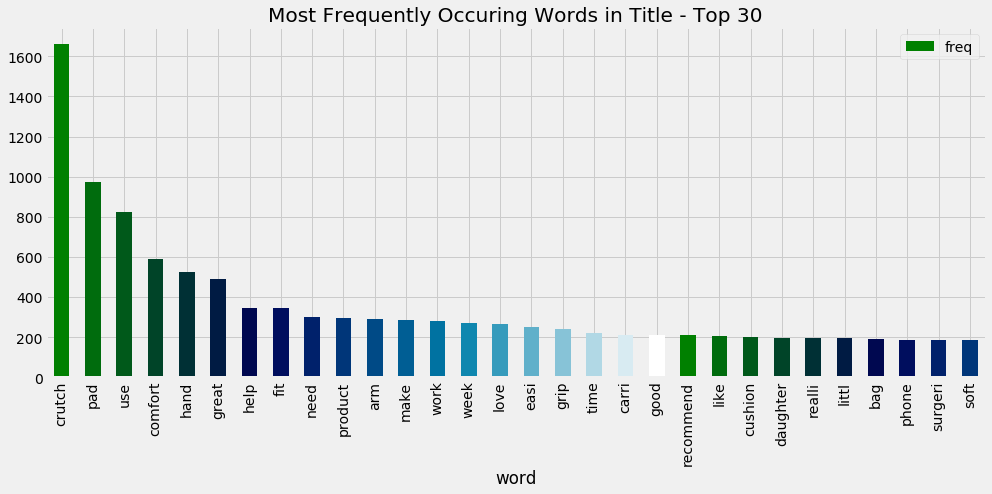

2484

Original Survey Size 2484


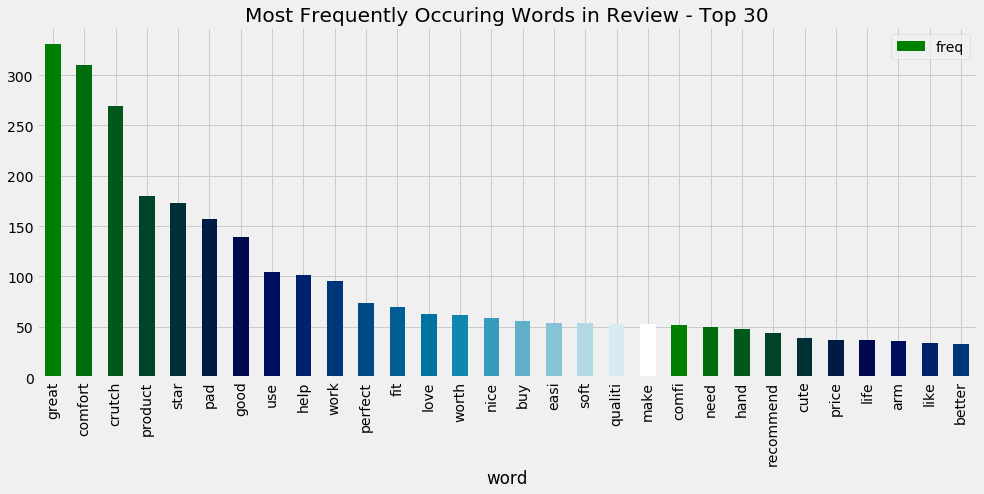

In [39]:
review_transfered = Normalize_Tokens(df['review'] , 'Title')
title_transfered = Normalize_Tokens(df['title'] , 'Review')

In [52]:
review_transfered.head()

,lema_text,orig_text
0,got hope hand would hurt use crutch comfort ha...,Got these in hopes that my hands would not hur...
1,product came fast cushi palm hand armpit,The product came very fast and it is very cush...
2,daughter look support crutch found onlin love ...,My daughter had to look for support for her cr...
3,student colleg super help carri around water b...,"I'm a student in college, and this was super h..."
4,bag get five star super handi would recommend ...,The crutch bag gets five stars for being super...


In [32]:
display(review_transfered)
display(title_transfered)

,lema_text,orig_text
0,got hope hand would hurt use crutch comfort ha...,Got these in hopes that my hands would not hur...
1,product came fast cushi palm hand armpit,The product came very fast and it is very cush...
2,daughter look support crutch found onlin love ...,My daughter had to look for support for her cr...
3,student colleg super help carri around water b...,"I'm a student in college, and this was super h..."
4,bag get five star super handi would recommend ...,The crutch bag gets five stars for being super...
5,ever friend need crutch part care packag use p...,"When ever a friend needs crutches, this will b..."
6,must crutch bunion surgeri asid comfort undera...,These are a MUST for my crutches after bunion ...
7,product perfect serv need need,The product was perfect and served the needs i...
8,job,Did the job!
9,http made old set aluminum crutch look feel li...,https://www.amazon.com/dp/B01DDRW752/ref=cm_cr...


,lema_text,orig_text
0,soft save hand arm,"Very soft, saves the hands and under arms"
1,work,It does work!
2,daughter love best support crutch,My daughter loves it. Best support for your cr...
3,super help carri around water bottl pen,and this was super helpful to carry around my ...
4,great idea super handi recommend reserv,"Great idea and super handy, but recommended wi..."
5,great pressur relief hand,Great pressure relief for your hands
6,must crutch bunion surgeri,These are a MUST for my crutches after bunion ...
7,work great,Work great!
8,good pad,Good padding
9,fit,Fit to a T


In [62]:
chatbox_mask = np.array(Image.open("image/chatbox.png"))
#chatbox_mask

In [65]:
def my_tf_color_func(dictionary, flag):
    if flag=='neg':
      def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        col = "hsl(13, 80%%, %d%%)" % ((10000 / (100 + dictionary[word]))+10)
        #print col
        return col
    else:
      def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        col = "hsl(81, 48%%, %d%%)" % ((10000 / (100 + dictionary[word]))-5)
        #print col
        return col
    return my_tf_color_func_inner

In [66]:
def HeadDict(dict_x, n):
    # Get items from the dictionary and sort them by
    # value key in descending (i.e. reverse) order
    sorted_x = sorted(dict_x.items(),
    reverse = True,
    key = lambda kv: kv[1])
    # Convert sorted dictionary to a list.
    dict_x_list = list(sorted_x)
    # Return the first `n` values from the dictionary only.
    return(dict(dict_x_list[:n]))

In [63]:
def generate_wordcloud(words, mask):
    word_cloud = WordCloud(width = 512, height = 512, background_color='white', mask=mask).generate(words)
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

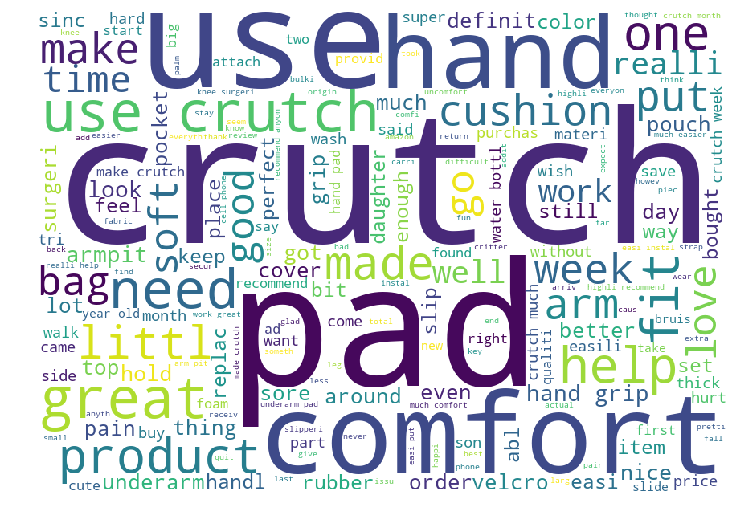

In [64]:
generate_wordcloud(''.join(review_transfered.lema_text.to_list()), chatbox_mask)

In [ ]:
lemma_corpus_freq_dist = Freq_DTM_lemma.to_dict()
## frequent to percentage 
lemma_corpus_pec_dist = dict((k,[v ,Total_Docs,float(v)/float(Total_Docs),sub1]) for k,v in lemma_corpus_freq_dist.items() if float(v)/float(Total_Docs)>0.000001)
lemma_corpus_pec_df = pd.DataFrame.from_dict(lemma_corpus_pec_dist, orient='index')

In [51]:
# Transform your mask into a new one that will work with the function:
transformed_chatbox_mask = np.ndarray((chatbox_mask.shape[0],chatbox_mask.shape[1],chatbox_mask.shape[2]), np.int32)

for i in range(len(chatbox_mask)):
    transformed_chatbox_mask[i] = list(map(transform_format, chatbox_mask[i]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [44]:
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=1000, mask=transformed_wine_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick')

# Generate a wordcloud
wc.generate(text)

# store to file
wc.to_file("img/wine.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

160477

Most reviews have less than 25 meaningful words. 

In [20]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(output.lema_text)

In [21]:
cv.get_feature_names()

[u'abad',
 u'abandon',
 u'abil',
 u'abl',
 u'abras',
 u'absolut',
 u'absorb',
 u'abus',
 u'accent',
 u'accept',
 u'access',
 u'accessori',
 u'accesssori',
 u'accid',
 u'accident',
 u'accommod',
 u'accord',
 u'account',
 u'accur',
 u'ach',
 u'achi',
 u'achil',
 u'acl',
 u'act',
 u'activ',
 u'actual',
 u'ad',
 u'add',
 u'addit',
 u'adequ',
 u'adjust',
 u'administ',
 u'admittedli',
 u'adopt',
 u'ador',
 u'adult',
 u'advanc',
 u'adventur',
 u'advert',
 u'advertis',
 u'advis',
 u'aesthet',
 u'affect',
 u'affili',
 u'afford',
 u'afraid',
 u'aftermarket',
 u'afterna',
 u'afterward',
 u'aga',
 u'age',
 u'aggrav',
 u'ago',
 u'agon',
 u'agoni',
 u'ahead',
 u'ahhh',
 u'aid',
 u'ail',
 u'air',
 u'airplan',
 u'airpod',
 u'airport',
 u'ajax',
 u'ak',
 u'aka',
 u'ala',
 u'alittl',
 u'allevi',
 u'allow',
 u'alon',
 u'alot',
 u'alphabet',
 u'alreadi',
 u'alter',
 u'altern',
 u'aluminum',
 u'alway',
 u'amanda',
 u'amaz',
 u'amazingli',
 u'amazon',
 u'ampl',
 u'amput',
 u'ampute',
 u'angl',
 u'anim',
 u'

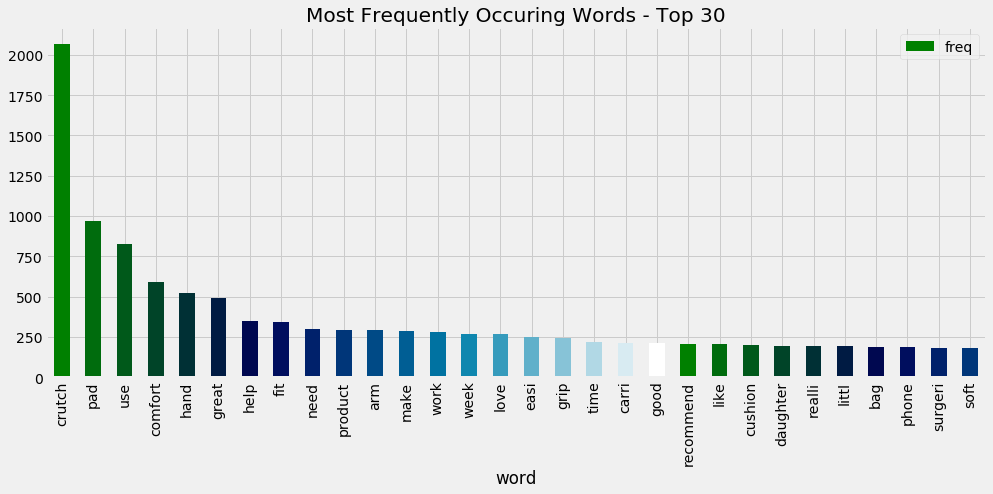

In [24]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(output.lema_text)
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 30")
plt.show()

The Above Bar plot gives us a rough idea about what customers mentioned most in their review. 

We can see that love is the most frequent word in the word suggesting that most of the people absolutely love alexa. Other frequent words that suggest alexa is doing well are amazing, like, great, works etc.